### Collision detection

In [6]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,r2rpy
from scipy.spatial.distance import cdist
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]
MuJoCo version:[2.3.2]


### Parse `Panda` with objects

In [7]:
xml_path = '../model/panda/franka_panda_w_objs.xml'
env = MuJoCoParserClass(name='Panda',rel_xml_path=xml_path,VERBOSE=True)
print ("[Panda] parsed.")

n_body:[37]
geom_names:['ground', 'panda_pedestal', 'panda_link_0_visual', 'panda_link_0_collision', 'panda_link_1_visual', 'panda_link_1_collision', 'panda_link_2_visual', 'panda_link_2_collision', 'panda_link_3_visual', 'panda_link_3_collision', 'panda_link_4_visual', 'panda_link_4_collision', 'panda_link_5_visual', 'panda_link_5_collision', 'panda_link_6_visual', 'panda_link_6_collision', 'panda_link_7_visual', 'panda_link_7_collision', 'panda_hand_visual', 'panda_hand_collision', 'panda_finger1_visual', 'panda_finger1_collision', 'panda_finger1_pad_collision', 'panda_finger2_visual', 'panda_finger2_collision', 'panda_finger2_pad_collision', 'work_space', 'obj_box_01', 'obj_box_02', 'obj_box_03', 'obj_box_04', 'obj_box_05', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05']
n_body:[29]
body_names:['world', 'panda_base', 'panda_pedestal', 'panda_link_0', 'panda_link_1', 'panda_link_2', 'panda_link_3', 'panda_link_4', 'panda_link_5', 'panda_

In [8]:
np.random.seed(seed=0)
obj_names = env.get_body_names(prefix='obj_')
n_obj = len(obj_names)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
colors[:,3] = 1.0
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos = [-1.0,0.1*obj_idx,0.01]
    obj_quat = [0,0,0,1]
    env.model.body(obj_name).ipos = obj_pos
    env.model.body(obj_name).iquat = obj_quat
    env.model.geom(obj_name).rgba = colors[obj_idx] # color
# Change table color
table_color = [0.65,0.64,0.68]
env.model.geom('panda_pedestal').rgba[:3] = table_color
env.model.geom('work_space').rgba[:3] = table_color
# Add transparency to geoms
for geom_name in env.geom_names:
    if geom_name == 'ground': continue
    env.model.geom(geom_name).rgba[3] = 0.8
# Place objects on the table
n_place = 10
obj2place_names = [obj_names[o_idx] 
                   for o_idx in np.random.permutation(n_obj)[:n_place].astype(int)]
x_range = [0.3,1.0]
y_range = [-0.5,0.5]
z_range = [1.0,1.0]
min_dist_btw_obj = 0.2 # minimum distance between objects
obj2place_poses  = np.zeros((n_place,3))
for o_idx in range(n_place):
    loop_cnt = 0
    while True:
        loop_cnt = loop_cnt + 1
        x = np.random.uniform(low=x_range[0],high=x_range[1])
        y = np.random.uniform(low=y_range[0],high=y_range[1])
        z = np.random.uniform(low=z_range[0],high=z_range[1])
        xyz = np.array([x,y,z])
        if o_idx >= 1:
            devc = cdist(xyz.reshape((-1,3)),obj2place_poses[:o_idx,:].reshape((-1,3)),
                         'euclidean')
            if devc.min() > min_dist_btw_obj: break # minimum distance between objects
        else:
            break
    obj2place_poses[o_idx,:] = xyz
for obj_idx,obj_name in enumerate(obj2place_names):
    env.model.body(obj_name).ipos = obj2place_poses[obj_idx]
print ("Done.")

Done.
Done.


### Solve IK while checking collision

In [9]:
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=True) # transparent
env.update_viewer(VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]))
env.update_viewer(VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
                  jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset

# Open gripper (prismatic joints)
env.forward(q=np.array([0,0,0,0,0,90,0])*np.pi/180.0,joint_idxs=env.rev_joint_idxs)
env.forward(q=[0.04,-0.04],joint_idxs=env.pri_joint_idxs)

# Set the primary and the secondary IK targets
ik_body_name = 'panda_eef'
p_trgt = np.array([0.8,0.0,1.2])
R_trgt = rpy2r(np.array([-180,0,180])*np.pi/180.0)

# Loop
q = env.get_q(joint_idxs=env.rev_joint_idxs)
imgs,img_ticks,max_tick = [],[],1000
while (env.tick < max_tick) and env.is_viewer_alive():
    # Get IK ingredients for the primary target
    J,err = env.get_ik_ingredients(
        body_name=ik_body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True)
    dq = env.damped_ls(J,err,stepsize=1,eps=1e-1,th=5*np.pi/180.0)
    # Update q and FK
    q = q + dq[env.rev_joint_idxs]
    env.forward(q=q,joint_idxs=env.rev_joint_idxs) # FK
    # Get contact information
    p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(
        must_include_prefix='panda')
    # Render
    env.plot_T(p=env.get_p_body(body_name=ik_body_name),
               R=env.get_R_body(body_name=ik_body_name),
               PLOT_AXIS=True,axis_len=0.2,axis_width=0.005,PLOT_SPHERE=False)
    env.plot_T(p=p_trgt,R=R_trgt,PLOT_AXIS=True,axis_len=0.2,axis_width=0.005,
               PLOT_SPHERE=False)
    # Render contact informations
    for (p_contact,f_contact,geom1,geom2) in zip(p_contacts,f_contacts,geom1s,geom2s):
        f_norm = np.linalg.norm(f_contact)
        f_uv = f_contact / (f_norm+1e-8)
        f_len = 0.3 # f_norm*0.05
        env.plot_arrow(p=p_contact,uv=f_uv,r_stem=0.01,len_arrow=f_len,rgba=[1,0,0,1],
                       label='')
        env.plot_arrow(p=p_contact,uv=-f_uv,r_stem=0.01,len_arrow=f_len,rgba=[1,0,0,1],
                       label='')
        label = '' # '[%s]-[%s]'%(geom1,geom2)
        env.plot_sphere(p=p_contact,r=0.02,rgba=[1,0.2,0.2,1],label=label)
    env.plot_T(p=[0,0,0],R=np.eye(3,3),PLOT_AXIS=True,axis_len=1.0)
    env.render()
    # Print and save image 
    if (env.tick)%(max_tick//10)==0 or (env.tick==1):
        print ("[%d/%d] IK error:[%.4f]"%(env.tick,max_tick,np.linalg.norm(err)))
        img = env.grab_image()
        imgs.append(img)
        img_ticks.append(env.tick)
# Close viewer
env.close_viewer()
print ("Done.")

[100/1000] IK error:[0.0009]
[100/1000] IK error:[0.0009]
[200/1000] IK error:[0.0004]
[200/1000] IK error:[0.0004]
[300/1000] IK error:[0.0002]
Pressed ESC
Quitting.
Done.
[300/1000] IK error:[0.0002]
Pressed ESC
Quitting.
Done.


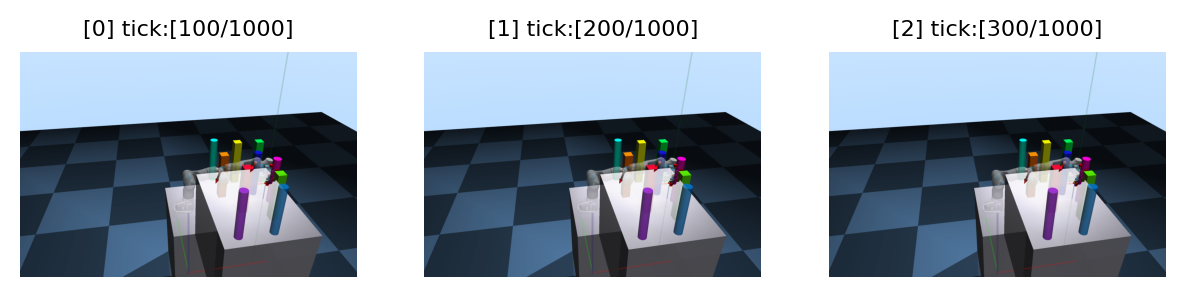

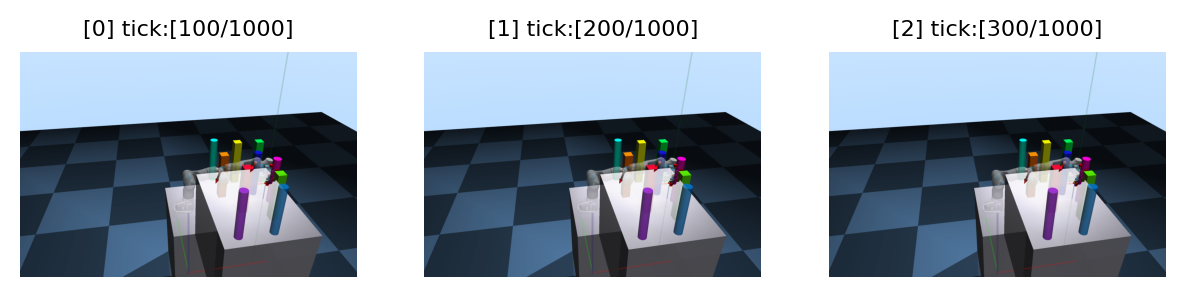

In [10]:
# Plot snapshots for Panda solving IK
n_row = np.ceil(len(imgs)/4).astype(np.int32)
fig = plt.figure(figsize=(10,1.5*n_row))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(np.ceil(len(imgs)/4).astype(np.int32),4,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%d] tick:[%d/%d]'%(i_idx,img_ticks[i_idx],max_tick),fontsize=8)
    ax.axis('off')
plt.show()    